## Assignment 2 Solutions 

### Aditya Ramdasi

Solving projectile motion equations as boundary value problems by 2 methods - Shooting and Relaxation

In [250]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, norm
import time

#### Given -

Mass of boulder = 100 kg

Since the problem at hand is a simple projectile motion, ignoring air resistance, we construct the following equations of motion in $x,y$ directions for the moving boulder - 

$$ \frac{dx}{dt} = v_x = v_0 \cos{\theta} \hspace{   
    \frac{dy}{dt} = v_y = v_0 \sin{\theta} $$ 
 //

\frac{dv_x}{dt} &=  \frac{d^2x}{dt^2} = 0 // 
\frac{dv_y}{dt} &= \frac{d^2y}{dt^2} = -g // $$

where $\theta$ is the angle of projection i.e. angle between the horizontal and the current velocity vector, and $g = 9.81$ m/s$^2$, the given standard acceleration value due to gravity, which is a constant. 

From the scenario described in the problem we can extract the following boundary conditions to solve our BVP (all values in SI units):

* $t_0 = 0, \hspace{3mm} x(t_0) = x_0 =  0, \hspace{3mm} y(0) = y_0 = + 100$
* $t_f = 15, \hspace{3mm} x(t_f) = x_f = +1000, \hspace{3mm} y(t_f) = y_f =  0$



### Analytical solution

We can solve for the initial velocities $u_x, u_y$ using simple 1D kinematic equations applied separately for $x, y$ directions (ignoring air resistance, of course). There is no acceleration due to gravity in the $x$ direction (constant velocity motion), only the $y$ direction. Considering this, we find the analytical values of $u_x, u_y$ as follows - 

$\begin{align*} 
s_x &= u_x * t_f \\ \implies u_x &= \frac{s_x}{t_f} = \frac{1000}{15} = 66.667 m/s \\
s_y &= u_y*t_f + \frac{1}{2}gt_f^2 \\  \implies u_y &= \frac{s_y + 0.5*gt_f^2}{t_f}  =  \frac{-100 + 0.5*(9.8)*(15)^2}{15} = 66.833 m/s
\end{align*}$

$\begin{align*}
v_y &= u_y - g*t_f = 66.833 - (9.8)*(15) = -80.166 m/s
\end{align*}$

This is analytical final y velocity value, the x value will remain the same.

Thus, the analytical values of initial velocities in $x$ and $y$ directions are:

$\begin{equation*} 
u_x = 66.667 m/s 
\end{equation*}$

$\begin{equation*} 
u_y = 66.837 m/s 
\end{equation*}$

### Numerical Solution - Approach 1

We first approach this problem's numerical solution with an iterative **shooting method** as follows -

### Iterative Shooting Method

In this method, we start with some random guess values of initial velocities $v_x$ and $v_y$, and evolve the system as an IVP, from the given initial positions using those as trial values of velocities. We record where the boulder lands with this time evolution (here we use RK4 to do this), and compute the *error vector* by subtracting the target vector from this position vector where it landed. The goal now is to **minimize this error vector**, or rather, its magnitude iteratively. 

To do this, we take numerical finite difference derivaties of the velocity components by evolving the system with originally chosen velocities and slightly perturbed velocities (done independently and successively for $v_x$ and $v_y$ and dividing the difference in their error vectors by a small $\Delta v$. This gives us the **Jacobian** matrix, whose elements tell us how small changes in initial velocity affect the finally achieved position of the boulder. (Basically we do a Taylor expansion of th error vectors upto the first-order). 

We then invert this Jacobian and take its dot product with the current error vector to produce a correction vector $[\Delta v_x, \Delta v_y]$. We add these corrections to our initial random guess of initial velocities, and repeat the entire process until the magnitude of the error vector goes below a certain set tolerance value, which controls the time and accuracy of conversion of our shooting method.

Having understood the algorithm, we now implement it in code -

#### Functions for time evolution (RK4), error vector, jacobian and actual shooting method

In [323]:
# Encoding the system's 4 differential equations in a single function
def derivatives(x, y, vx, vy):
    return vx, vy, 0, -g  # Return dx/dt, dy/dt, dvx/dt, dvy/dt


# RK4 integrator to evolve the system from 0 to Tf in increments of dt and return x, y, vx, vy at each step
def rk4_trajectory(x0, y0, vx0, vy0, Tf, dt):
    """
    Evolve the projectile motion in 2D and return arrays of positions (x, y) and velocities (vx, vy).
    """
    n_steps = int(Tf / dt) + 1  # Number of time steps (+1 for the final step)

    # Initialize one n_steps X 4 array for x, y, vx, vy at each time step
    trajectory = np.zeros((n_steps, 4))  # Each row will store [x, y, vx, vy]

    # Set initial conditions (0th row of trajectory array)
    trajectory[0] = [x0, y0, vx0, vy0]

    # Time evolution loop
    for i in range(1, n_steps):  # start from 1 since 0th is initialized
        x, y, vx, vy = trajectory[i-1]  # Get current state

        # RK4 steps to compute the intermediate steps for this step
        k1x, k1y, k1vx, k1vy = derivatives(x, y, vx, vy)
        k2x, k2y, k2vx, k2vy = derivatives(x + dt*k1x/2, y + dt*k1y/2, vx + dt*k1vx/2, vy + dt*k1vy/2)
        k3x, k3y, k3vx, k3vy = derivatives(x + dt*k2x/2, y + dt*k2y/2, vx + dt*k2vx/2, vy + dt*k2vy/2)
        k4x, k4y, k4vx, k4vy = derivatives(x + dt*k3x,   y + dt*k3y,   vx + dt*k3vx,   vy + dt*k3vy)

        # Update position and velocity using the values calculated for intermediate steps above
        trajectory[i, 0] = x + dt*(k1x + 2 * k2x + 2 * k3x + k4x)/6.0  # Update x value
        trajectory[i, 1] = y + dt*(k1y + 2 * k2y + 2 * k3y + k4y)/6.0  # Update y value
        trajectory[i, 2] = vx + dt*(k1vx + 2 * k2vx + 2 * k3vx + k4vx)/6.0  # Update vx value
        trajectory[i, 3] = vy + dt*(k1vy + 2 * k2vy + 2 * k3vy + k4vy)/6.0  # Update vy value

    return trajectory  # returns (n_steps x 4) filled array with x, y, vx, vy at every timestep


#  Function to calculate error vector after every time evolution 
def err_vect(x0, y0, vx0, vy0, x_target, y_target, Tf, dt):
    """
    Compute the error between the final position after evolving the system (using x0,y0,vx0,vy0) and the target position.
    """
    # Evolve system from (x0,y0) with initial velocity (vx0, vy0)
    trajectory = rk4_trajectory(x0, y0, vx0, vy0, Tf, dt)  

    # Take out final x, y position from the trajectory (columns 0 and 1)
    achieved_pos = trajectory[-1, 0:2]  

    # Convert input target coordinates into a vector for subtraction
    target_pos = np.array([x_target, y_target])
    
    return achieved_pos - target_pos  # Return the error vector (delta x, delta y)


# Function to calculate jacobian matrix for first-order Taylor expansion (numerical derivative)
def jacobian(x0, y0, vx0, vy0, x_target, y_target, Tf, dt, dv=1e-4):
    """
    Numerically calculate the Jacobian matrix with respect to initial velocities (vx0, vy0).
    """
    jacob = np.zeros((2, 2))  # Initialize 2x2 Jacobian matrix to store values of derivatives
    
    error_orig = err_vect(x0, y0, vx0, vy0, x_target, y_target, Tf, dt)  # Original error vector
    
    # Adding a small change to vx0
    modified_vx = vx0 + dv  # Perturb vx0 by a small amount dv, vy0 remains the same
    error_mod_vx = err_vect(x0, y0, modified_vx, vy0, x_target, y_target, Tf, dt)  # Calculate error vector with modified vx0
    jacob[:, 0] = (error_mod_vx - error_orig) / dv  # Partial derivative w.r.t. vx0

    # Adding a small change to vy0
    modified_vy = vy0 + dv  # Perturb vy0 by a small amount dv, vx0 remains the same
    error_mod_vy = err_vect(x0, y0, vx0, modified_vy, x_target, y_target, Tf, dt)  # Calculate error vector with modified vy0
    jacob[:, 1] = (error_mod_vy - error_orig) / dv  # Partial derivative w.r.t. vy0

    return jacob  # Return the completed Jacobian matrix


# Finally, we now write the function for our actual shooting method to iteratively adjust initial velocities to hit the target
def shooting_method(x0, y0, vx0_init, vy0_init, x_target, y_target, Tf, dt, max_iter, tol):
    """
    Solve for the initial velocities (vx0, vy0) that hit the target using iterative shooting.
    """
    vx0, vy0 = vx0_init, vy0_init  # Set initial guesses for velocity

    for i in range(max_iter):  # For each iteration
        error_vec = err_vect(x0, y0, vx0, vy0, x_target, y_target, Tf, dt)  # Compute the error vector
        error_norm = np.sqrt(error_vec[0]**2 + error_vec[1]**2)  # Compute its magnitude

        if error_norm < tol:  # If the error vector magnitude is within the given tolerance
            return vx0, vy0, i  # Return the current value of initial velocities, and current iteration number. Solution found.

        # If not, then compute Jacobian matrix and invert that to get delta_v correction
        jacob = jacobian(x0, y0, vx0, vy0, x_target, y_target, Tf, dt)  # Jacobian matrix
        jacob_inv = np.linalg.inv(jacob)  # Invert the Jacobian matrix
        delta_v = -np.dot(jacob_inv, error_vec)  # Compute delta_vx, delta_vy as corrections to initial velocities

        vx0 = vx0 + delta_v[0]  # Update vx0 with computed delta _vx correction
        vy0 = vy0 + delta_v[1]  # Update vy0 with computed delta_vy correction

    return vx0, vy0  # After iterating until max_iter is reached, return the best solution


We now put the specified initial conditions, integration and shooting parameters and given value of $g$

In [324]:
## Initial conditions, parameters, and constants 

## Initial conditions
x0, y0 = 0, 100                        # considering the given figure, origin as given in the figure
x_target, y_target = 1000, 0           # coordinates of landing according to chosen origin (1km = 1000m)
Tf = 15                                # given time of motion in seconds, starting at t = 0

# Integration and shooting method parameters
dt = 1  # Time step for the RK4 integration
tol = 1e-5  # Tolerance for the error vector norm
max_iter = 10


# Constants (given values) 
g = 9.81  # given gravitational acceleration (m/s^2)

# Initial guess values for velocity components 
vx0_init = 50.0
vy0_init = 50.0

### Driver code 

In [325]:
%%time 
# Generate the projectile trajectory using the initial guess velocities 
trajectory_init = rk4_trajectory(x0, y0, vx0_init, vy0_init, Tf, dt)

# Solve the problem by finding the correct initial velocities using the shooting method
vx0_solution, vy0_solution, n_iters = shooting_method(x0, y0, vx0_init, vy0_init, x_target, y_target, Tf, dt, max_iter, tol)

# Generate the projectile trajectory using the found initial velocities  
trajectory_solution = rk4_trajectory(x0, y0, vx0_solution, vy0_solution, Tf, dt)

# Extract x, y positions (0th and 1st column) for initial guess velocities
x_init, y_init = trajectory_init[:, 0], trajectory_init[:, 1]

# Extract x, y positions (0th and 1st column) for found initial velocities
x_solu, y_solu = trajectory_solution[:, 0], trajectory_solution[:, 1] 

#  Also extract vx, vy velocity components (2nd and 3rd column) for final velocity of solution trajectory
vx_final_solu, vy_final_solu = trajectory_solution[-1, 2], trajectory_solution[-1, 3] 

CPU times: user 1.42 ms, sys: 0 ns, total: 1.42 ms
Wall time: 1.3 ms


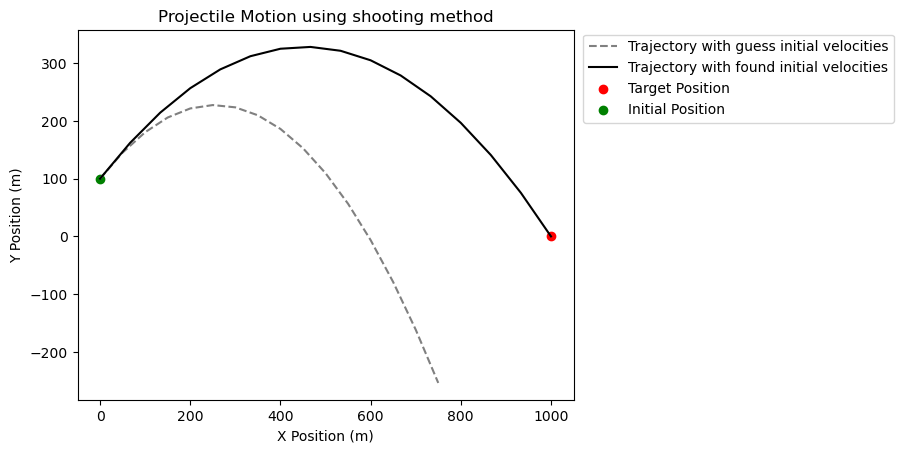

In [326]:
# Plotting

# Plot both the trajectories
plt.plot(x_init, y_init, label='Trajectory with guess initial velocities', ls='--', color='grey')  # Plot the initial guess trajectory
plt.plot(x_solu, y_solu, label='Trajectory with found initial velocities', color='black')  # Plot the final found trajectory

plt.scatter(target_position[0], target_position[1], color='red', label='Target Position')  # Mark the target
plt.scatter(x0, y0, color='green', label='Initial Position')  # Mark the start

plt.xlabel('X Position (m)')  # Label x-axis
plt.ylabel('Y Position (m)')  # Label y-axis
plt.title('Projectile Motion using shooting method')  # Set plot title
plt.legend(loc=(1.02, 0.75))  # Add legend
plt.show()  # Display the plot

In [327]:
vx0_solution, vy0_solution = np.round(vx0_solution, 3), np.round(vy0_solution, 3)
vx_final_solu, vy_final_solu = np.round(vx_final_solu, 3), np.round(vy_final_solu,3)

print("The converged values of initial x,y velocities (in m/s) for the boulder to reach (1000,0) from (0,100) in 15 seconds are:\n", vx0_solution, vy0_solution)

print("The final x,y velocities (in m/s) of the boulder following the found trajectory, at (1000,0) are:\n", vx_final_solu, vy_final_solu) 

The converged values of initial x,y velocities (in m/s) for the boulder to reach (1000,0) from (0,100) in 15 seconds are:
 66.667 66.908
The final x,y velocities (in m/s) of the boulder following the found trajectory, at (1000,0) are:
 66.667 -80.242


##### Now we approach the same problem, but using a relaxation approach

In this approach, we do not use an IVP solver at all to compute our error vectors. Instead, we initialize a mesh of grid points ($M$) with some randomized initial ($x,y,v_x, v_y$) values at every mesh point. We convert our given differential equations to a set of $N$ coupled linear equations, but in discretized form, to get our **Finite difference equations**. We then compute our error vectors for each grid point by using the following equation (here $y_k$ stands for each of the 4 variables mentioned above, $t_k$ stands for discretized time) - 

$\begin{equation} \vec{E_k} = (\vec{y_k} - \vec{y_{k-1}}) - (t_k - t_{k-1})g( \frac{1}{2} (t_k + t_{k+1}, y_k + y_{k+1})
\end{equation}$

We then compute an $N \times 2N$ Jacobian matrix at each gridpoint and stack them into a big $NM \times NM$ matrix, cleverly arranged to pick out the correct $\Delta y_k, \Delta y_{k-1}, \Delta y_{k+1}$ values. We then solve this matrix equation to get our correction terms for each of the velocities at every grid point, which we add to our initial values of velocities, and repeat. Once this correction vector's norm goes below a set tolerance, we terminate and output the final mesh, and get our initial velocities from the mesh. Usually this method converges in one iteration. 

We now implement this in code as follows -

In [328]:
# Parameters and constants
g = -9.8  # Gravitational acceleration
Mx = 4   # Number of mesh points for x 
My = 4   # Number of mesh points for y 
Nx = 2    # Number of coupled differential equations for x
Ny = 2    # Number of coupled differential equations for y
T = 15.0  # Total time
dt = T / (Mx - 1)  # Time step size
tolerance = 1e-5   # norm of error vector should fall below this to converge
max_iterations = 1  # large number of maximum iterations

# Boundary conditions (given)
x0, y0 = 0.0, 100.0   # Initial position at t=0
xf, yf = 1000.0, 0.0  # Final position at t=15

In [329]:
# Define relevant functions for relaxation method

# Initializing inital guess values to be all 1 for x and y mesh, dealing with x and y independently
x_mesh = np.ones(shape=(Nx, Mx))
y_mesh = np.ones(shape=(Ny, My))


# Function to construct the finite difference matrix for x or y
def construct_fd_matrix(M, N, dt):
    matrix = np.zeros((M * N, M * N))  # initialize the big (NM x NM) matrix
    
    for i in range(1, M):
        k = i * N        # scaling position of our N x 2N  block matrix in multiples of N to shift rightwards 

        # Local (N x 2N) block matrix
        local_block = np.array([[-1, -dt/2 , 1 , -dt/2],
                                [0,   -1 ,   0,    1]])
        
        # Insert this block into the global (NM x NM) matrix
        matrix[k-1:k+N-1, k-N:k+N] = local_block       # proper row and column indexing ensured
    
    # Special handling for the first and last points (fixed positions)
    matrix[0, 0] = 1.0  # Velocity update at first point
    
    matrix[-1, -2] = 1.0  # Velocity update at last point
    
    return matrix

# Function to compute the error vector for x  (constant velocity, no g term)
def compute_error_x(mesh, M, N, dt, x0, xf):
    
    error = np.zeros(M * N)
    error[0] = mesh[0][0] - x0             # usage of partial error vector from boundary condition
    error[-1] = mesh[0][-1] - xf
     # fill in the rest of the error vector
    for i in range(1, M):  # Iterate from 1,M
        k = i * N - 1
        error[k] = mesh[0][i] - mesh[0][i-1] - (dt/2)*(mesh[1][i] + mesh[1][i-1])
        error[k+1] = mesh[1][i] - mesh[1][i-1]
    return error

# Function to compute the error vector for y  (net gravitational acceleration, modified error vector due to g term)
def compute_error_y(mesh, M, N, dt, y0, yf):
    
    error = np.zeros(M * N)
    # usage of partial error vector from boundary condition
    error[0] = mesh[0][0] - y0
    error[-1] = mesh[0][-1] - yf

    # fill in the rest of the error vector
    for i in range(1, M):
        k = i*N  - 1
        error[k]   = mesh[0][i] - mesh[0][i-1] - (dt/2)*(mesh[1][i] + mesh[1][i-1] )
        error[k+1] = mesh[1][i] - mesh[1][i-1] - dt*g 
    return error

# Relaxation method to solve for x and vx
def relax_x(mesh, M, N, dt, x0, xf, tolerance):
    fd_matrix = construct_fd_matrix(M, N, dt)
    fd_matrix_inv = inv(fd_matrix)  # Pre-compute the inverse of the finite difference matrix

    for iteration in range(max_iterations):
        error = compute_error_x(mesh, M, N, dt, x0, xf)
        delta = np.dot(fd_matrix_inv, -error)
        
        # Check if the delta norm is below the tolerance
        if norm(delta) < tolerance:
            break  # if yes then stop

        # add the delta to the initial guess mesh values
        for j in range(0,M):
            mesh[:,j] += delta[N*j:N*j+2]
    
    return mesh     # return the updated mesh

def relax_y(mesh, M, N, dt, y0, yf, tolerance):
    
    fd_matrix = construct_fd_matrix(M, N, dt)
    fd_matrix_inv = inv(fd_matrix)  # Pre-compute the inverse of the finite difference matrix

    for iteration in range(max_iterations):
        error = compute_error_y(mesh, M, N, dt, y0, yf)

        delta = np.dot(fd_matrix_inv, -error)
        
        # Check if the delta norm is below the tolerance
        if norm(delta) < tolerance:
            break  # if yes then stop

          # add the delta to the initial guess mesh values
        for j in range(0,M):
            mesh[:,j] += delta[N*j:N*j+2]
            
   
    return mesh # return the updated mesh


#### Driver code

In [330]:
%time

# Perform relaxation separately for x and y
x_mesh = relax_x(x_mesh, Mx, Nx, dt, x0, xf, tolerance)
y_mesh = relax_y(y_mesh, My, Ny, dt, y0, yf, tolerance)

vx_initial = np.round(x_mesh[1][0], 3)
vy_initial = np.round(y_mesh[1][0], 3)

vx_final = np.round(x_mesh[1][-1], 3)
vy_final = np.round(y_mesh[1][-1], 3)



CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs


In [331]:
print('The initial velocity (x,y) component values converged upon from relaxation method are:\n', vx_initial, vy_initial)
print('The final velocity (x,y) component values converged upon from relaxation method are:\n', vx_final, vy_final)

The initial velocity (x,y) component values converged upon from relaxation method are:
 66.667 66.833
The final velocity (x,y) component values converged upon from relaxation method are:
 66.667 -80.167


There is no trajectory to be obtained from relaxation method, unless we feed in the above obtained initial velocity values to an IVP scheme (like RK4) and get the time evolution. Just to verify the given boundary conditions are satisfied (the target lands onto the solution), we print the obtained initial and final positions - 

In [332]:
x_initial = x_mesh[0][0]
y_initial = y_mesh[0][0]
x_final = x_mesh[0][-1]
y_final = y_mesh[0][-1]

print("Initial (x,y) positions:", x_initial, y_initial)
print("Final (x,y) positions:", x_final, y_final)

Initial (x,y) positions: 0.0 100.0
Final (x,y) positions: 1000.0 0.0


### Comparison between Shooting and Relaxation method 



#### Efficiency

To compare their efficiency, we have a look at the recorded time values for running both methods, and even though the actual values differ a little bit for every execution, their respective orders of magnitude is the same. While *shooting method* takes $ \approx 10^{-3}$ seconds to run, the relaxation method takes $ \approx 10^{-6}$ seconds (micro seconds). Although it would be more ideal to compare the run times for the exact same number of time steps for both methods, here shooting method only has 3x more steps than relaxation method, while the run time is roughly 1000 times larger. Hence, we can get a good ballpark estimate of the efficiency of both methods, by comparing their run times for roughly the same number of time steps (same order of magnitude)

#### Accuracy

We know the analytical values of the initial values of $x$ and $y$ velocities from the calculation above. We also found those values from both shooting and relaxation methods. The comparison values are as follows - 

1. Analytical method: Initial velocities (66.667, 66.833) & Final velocities (66.666, -80.166)
2. Shooting method: Initial velocities (66.667, 66.908) & Final velocities (66.667, -80.242)
3. Relaxation method: Initial velocities (66.667, 66.833) & Final velocities (66.667 -80.167)

From these values itself we can see that the relaxation method is more accurate and in agreement with the analytical solution, compared to the shooting method values, for both initial and final velocities.

Thus, the relaxation method is much better in terms of both accuracy and efficiency. 

We can also compare the accuracy of both methods by subtracting the trajectories evolved from their obtained initial velocities, from the analytical trajectory and plot the difference with time.

In [333]:
# analytical run 

x0, y0 = 0, 100
trajectory1 = rk4_trajectory(x0, y0, 66.667, 66.833, Tf, dt)
x1, y1 = trajectory1[:, 0], trajectory1[:, 1]

# shooting method run
trajectory2 = rk4_trajectory(x0, y0, 66.667, 66.908, Tf, dt)
x2, y2 = trajectory2[:, 0], trajectory2[:, 1]

# relaxation method run

trajectory3 = rk4_trajectory(x0, y0, 66.667, 66.833, Tf, dt)
x3, y3 = trajectory3[:, 0], trajectory3[:, 1]